In [108]:
import pandas as pd
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
import sys
sys.path.append("../scripts")
import compute_diversity_measures
import seaborn as sns

In [136]:
fname_mutations_all_samples = 'mutations_all_samples.csv'
output_dir = './plots_diversity/'

df = pd.read_csv(fname_mutations_all_samples)

df['frequency'] = df['frequency_reads_var']
df['coverage'] = df['n_reads_tot']
df['position'] = df['Pos']

In [110]:
# Post-processing filtering of mutation calling

# filter out where Frq_ave == 0.0 
# that is something unexpected happening in ShoRAH which is due to the super high coverage
df = df[df['Frq_ave']!=0]

# strand bias test 
df = df[df['Pval']>=0.05]

# minimum read support
minimum_read_support = 50 
df = df[df['n_reads_var']>=minimum_read_support]

# minimum mutation frequency
minimum_frequency_threshold = 0.001 
df = df[df['frequency_reads_var']>=minimum_frequency_threshold]

In [111]:
replicates = df['patient'].unique()
passages = df['passage'].unique()
samples = df['sample'].unique()

In [112]:
genome_length = 9228

In [113]:
df_diversity = pd.DataFrame()

for sample in samples:
    for passage in passges:
        for replicate in replicates:
            
            df_temp = df[df['sample']== sample]
            df_temp = df_temp[df_temp['passage']==passage]
            df_temp = df_temp[df_temp['patient']==replicate]
            
            temp_dict = {'sample': sample, 
                         'passage': passage, 
                         'replicate': replicate,
                         'sum_mutation_frq': df_temp["frequency"].sum(), 
                         'mean_mutation_frq': df_temp["frequency"].mean(), 
                         'sem_mutation_frq': sem(df_temp["frequency"].to_numpy()), 
                         'population_nucleotide_diversity': compute_diversity_measures.population_nucleotide_diversity(df_temp, genome_length), 
                         'mean_pos_Shannon_entropy': compute_diversity_measures.mean_pos_Shannon_entropy(df_temp, genome_length),
                         'number_of_polymorphisms': compute_diversity_measures.number_of_polymorphisms(df_temp),
        
                        }
            df_diversity = df_diversity.append(temp_dict, ignore_index=True)

In [114]:
df_wildtype = df_diversity[df_diversity['sample']=='wild_type']
df_ko = df_diversity[df_diversity['sample']=='dicer_ko']
df_overexpressed = df_diversity[df_diversity['sample']=='dicer_overexpressed']

In [140]:
def plot_average_and_per_replicate(df_diversity, col_name_diversity, output_dir): 
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    replicates = df_diversity['replicate'].unique()
    passages = df_diversity['passage'].unique()
    
    df_wildtype = df_diversity[df_diversity['sample']=='wild_type']
    df_ko = df_diversity[df_diversity['sample']=='dicer_ko']
    df_overexpressed = df_diversity[df_diversity['sample']=='dicer_overexpressed']


    for df,color,name in zip([df_wildtype, df_ko, df_overexpressed], 
                        ['#F2C14E', '#368F8B', '#F15BB5'], 
                        ['wild type', 'dicer knockout', 'dicer overexpressed']):
        average_sum_mutation_frq = [np.mean(df[df['passage']== passage][col_name_diversity]) for passage in passages]
        ax1.plot(passages, average_sum_mutation_frq, c=color, marker='x', label=name)

    ax1.set_xticks([1,5,10])
    ax1.set_title('Average over replicates')
    ax1.set_ylabel(col_name_diversity)
    ax1.legend()

    for replicate in replicates:
        df_wildtype_rep = df_wildtype[df_wildtype['replicate']==replicate]
        ax2.plot(df_wildtype_rep['passage'], df_wildtype_rep[col_name_diversity] ,marker='x', c = '#F2C14E', label='wild type')

        df_ko_rep = df_ko[df_ko['replicate']==replicate]
        ax2.plot(df_ko_rep['passage'], df_ko_rep[col_name_diversity] ,marker='x', c = '#368F8B', label='dicer knockout')

        df_overexpressed_rep = df_overexpressed[df_overexpressed['replicate']==replicate]
        ax2.plot(df_overexpressed_rep['passage'], df_overexpressed_rep[col_name_diversity] ,marker='x', c = '#F15BB5', label='dicer overexpressed')

    ax2.set_xticks([1,5,10])
    fig.tight_layout()
    fig.savefig(output_dir+"Plot_"+col_name_diversity+".averaged.pdf") 


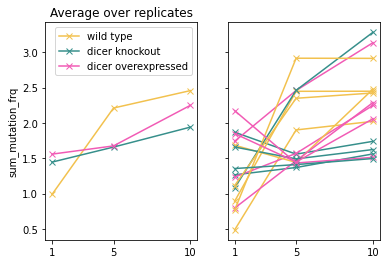

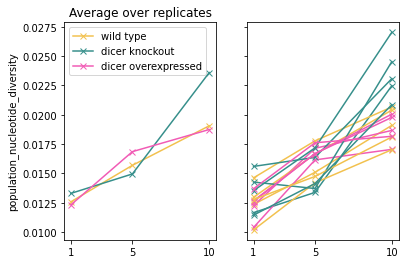

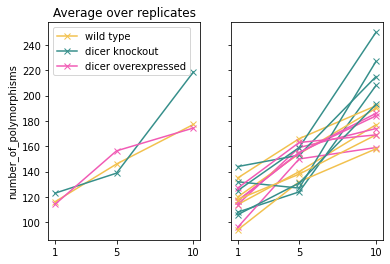

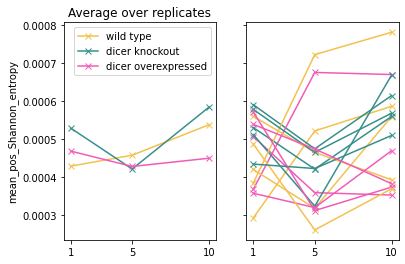

In [149]:
plot_average_and_per_replicate(df_diversity, 'sum_mutation_frq', output_dir)

plot_average_and_per_replicate(df_diversity, 'population_nucleotide_diversity', output_dir)

plot_average_and_per_replicate(df_diversity, 'number_of_polymorphisms', output_dir)

plot_average_and_per_replicate(df_diversity, 'mean_pos_Shannon_entropy', output_dir)

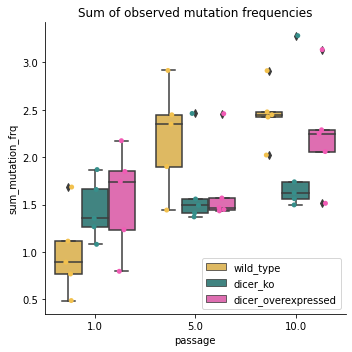

In [150]:
# sum_mutation_frq

g = sns.catplot(
        data=df_diversity,
        x="passage",
        y="sum_mutation_frq",
        hue="sample",
        #col="passage",
        #row='variable',
        kind="box",
        #row_order=['100', '1000', '10000'] , 
        hue_order=['wild_type', 'dicer_ko', 'dicer_overexpressed'] ,
        legend=False, 
        sharex=True,
        margin_titles=True,
        palette=sns.color_palette(['#F2C14E', '#368F8B', '#F15BB5']),
    )

g = sns.stripplot(
        data=df_diversity,
        x="passage",
        y="sum_mutation_frq",
        hue="sample",
        #col="passage",
        #row='variable',
        jitter=True,
        dodge=True, 
        #row_order=['100', '1000', '10000'] , 
        hue_order=['wild_type', 'dicer_ko', 'dicer_overexpressed'] ,
        #alpha=0.5,
        marker ='o',
        palette=sns.color_palette(['#F2C14E', '#368F8B', '#F15BB5']),
    )

handles, labels = g.get_legend_handles_labels()
# specify just one legend
l = g.legend(handles[0:3], labels[0:3])
g.set_title('Sum of observed mutation frequencies')

fig = g.figure
fig.tight_layout()
fig.savefig(output_dir+"Boxplot_sum_observed_mutation_frequencies.pdf") 